In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 60.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset --unzip -p /content/data/

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other


In [ ]:
data_dir = '/content/data'
img_dir = os.path.join(data_dir,'img_align_celeba', 'img_align_celeba')
attr_file = os.path.join(data_dir, 'list_attr_celeba.csv')

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, data, transform=None):
        self.img_dir = img_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, attrs = self.data[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Map attribute: -1 (Old) -> 0, 1 (Young) -> 1
        label = (attrs + 1) // 2
        return image, int(label)

In [ ]:
df=pd.read_csv(attr_file).sample(50000,random_state=42)
data=df[['image_id','Young']].to_numpy()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # scale images to [-1,1]
])

# Create dataset
celeba_dataset = CelebADataset(img_dir, data, transform=transform)
total_size = len(celeba_dataset)
print("Total images:", total_size)

# Split into 70% training, 20% validation, 10% testing
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(celeba_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Total images: 50000


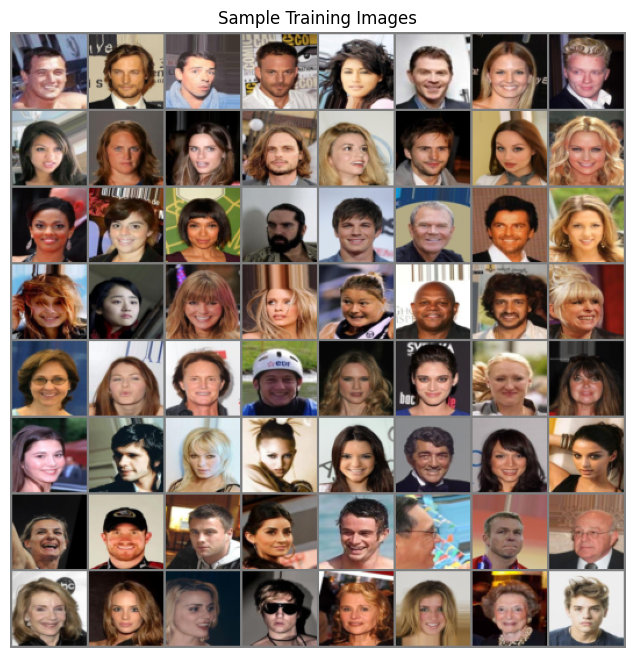

In [ ]:
# Visualize a grid of sample images from the training set
def imshow(img, title=""):
    img = img / 2 + 0.5  # unnormalize back to [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow=8), title="Sample Training Images")

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3x64x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),        # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),      # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),      # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),      # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),        # 1x1
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)  # Flatten to [batch_size, 1]

In [ ]:
# Hyperparameters
d_lr = 0.0001
g_lr = 0.0001
latent_dim=128
weight_clip = 0.01
n_critic = 5
num_epochs = 30

# Initialize models
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Use RMSprop instead of Adam for WGAN
optimizer_G = optim.RMSprop(generator.parameters(), lr=g_lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=d_lr)

#Log loss
G_losses = []
D_losses = []

Epoch 1/30: 100%|██████████| 137/137 [02:33<00:00,  1.12s/it, D_Loss=-1.28, G_Loss=0.636]


Epoch [1/30] Loss D: -1.2845, Loss G: 0.6358



Epoch 2/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.51, G_Loss=0.744]


Epoch [2/30] Loss D: -1.5052, Loss G: 0.7438



Epoch 3/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.48, G_Loss=0.736]


Epoch [3/30] Loss D: -1.4837, Loss G: 0.7358



Epoch 4/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.47, G_Loss=0.738]


Epoch [4/30] Loss D: -1.4679, Loss G: 0.7383



Epoch 5/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.47, G_Loss=0.733]



Epoch [5/30] Loss D: -1.4682, Loss G: 0.7326


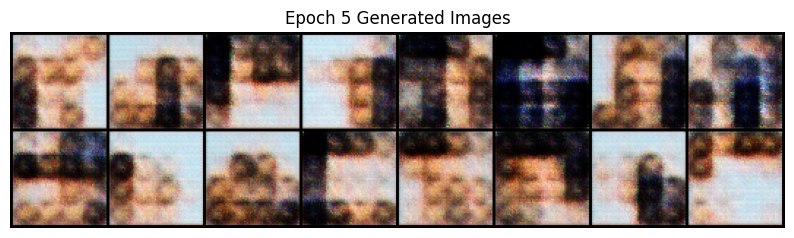

Epoch 6/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.43, G_Loss=0.721]


Epoch [6/30] Loss D: -1.4326, Loss G: 0.7214



Epoch 7/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.4, G_Loss=0.708]


Epoch [7/30] Loss D: -1.4047, Loss G: 0.7078



Epoch 8/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.39, G_Loss=0.694]


Epoch [8/30] Loss D: -1.3863, Loss G: 0.6943



Epoch 9/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.35, G_Loss=0.673]


Epoch [9/30] Loss D: -1.3521, Loss G: 0.6730



Epoch 10/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.38, G_Loss=0.689]



Epoch [10/30] Loss D: -1.3789, Loss G: 0.6889


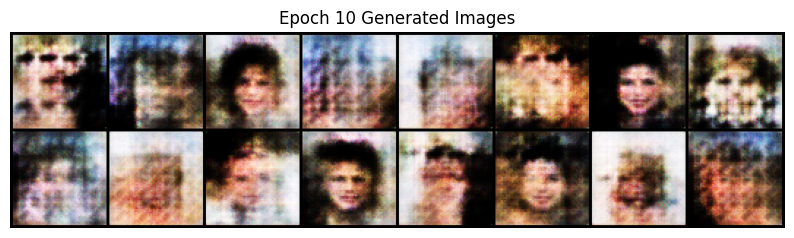

Epoch 11/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.32, G_Loss=0.677]


Epoch [11/30] Loss D: -1.3246, Loss G: 0.6768



Epoch 12/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.32, G_Loss=0.678]


Epoch [12/30] Loss D: -1.3168, Loss G: 0.6784



Epoch 13/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.28, G_Loss=0.668]


Epoch [13/30] Loss D: -1.2810, Loss G: 0.6677



Epoch 14/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.23, G_Loss=0.64]


Epoch [14/30] Loss D: -1.2329, Loss G: 0.6397



Epoch 15/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.21, G_Loss=0.635]



Epoch [15/30] Loss D: -1.2131, Loss G: 0.6346


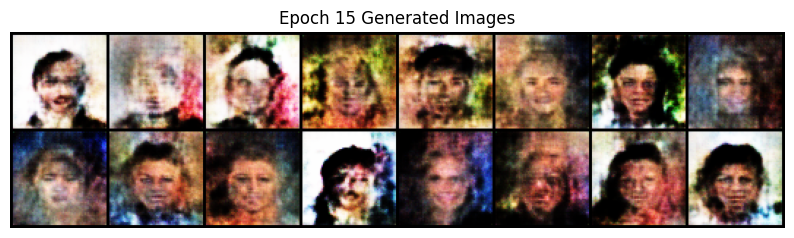

Epoch 16/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.16, G_Loss=0.617]


Epoch [16/30] Loss D: -1.1606, Loss G: 0.6165



Epoch 17/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.14, G_Loss=0.59]


Epoch [17/30] Loss D: -1.1357, Loss G: 0.5896



Epoch 18/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.12, G_Loss=0.609]


Epoch [18/30] Loss D: -1.1227, Loss G: 0.6087



Epoch 19/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.1, G_Loss=0.597]


Epoch [19/30] Loss D: -1.0951, Loss G: 0.5965



Epoch 20/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.09, G_Loss=0.567]



Epoch [20/30] Loss D: -1.0865, Loss G: 0.5673


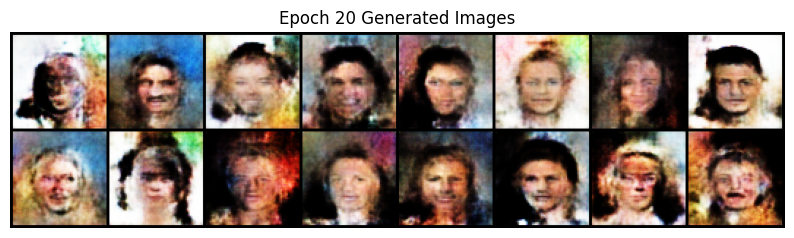

Epoch 21/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.08, G_Loss=0.559]


Epoch [21/30] Loss D: -1.0757, Loss G: 0.5590



Epoch 22/30: 100%|██████████| 137/137 [02:36<00:00,  1.14s/it, D_Loss=-1.04, G_Loss=0.554]


Epoch [22/30] Loss D: -1.0424, Loss G: 0.5542



Epoch 23/30: 100%|██████████| 137/137 [02:35<00:00,  1.13s/it, D_Loss=-1.03, G_Loss=0.544]


Epoch [23/30] Loss D: -1.0318, Loss G: 0.5441



Epoch 24/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-1.01, G_Loss=0.538]


Epoch [24/30] Loss D: -1.0142, Loss G: 0.5379



Epoch 25/30: 100%|██████████| 137/137 [02:35<00:00,  1.13s/it, D_Loss=-0.987, G_Loss=0.501]



Epoch [25/30] Loss D: -0.9872, Loss G: 0.5009


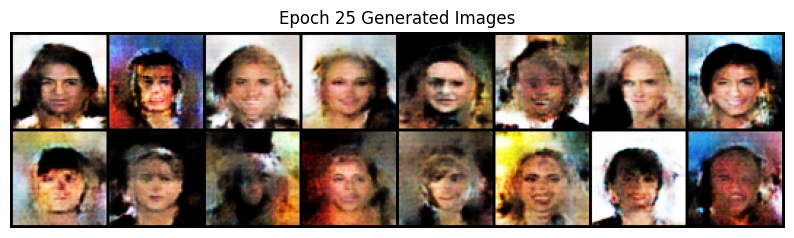

Epoch 26/30: 100%|██████████| 137/137 [02:35<00:00,  1.13s/it, D_Loss=-0.979, G_Loss=0.533]


Epoch [26/30] Loss D: -0.9792, Loss G: 0.5330



Epoch 27/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-0.961, G_Loss=0.489]


Epoch [27/30] Loss D: -0.9615, Loss G: 0.4894



Epoch 28/30: 100%|██████████| 137/137 [02:35<00:00,  1.14s/it, D_Loss=-0.942, G_Loss=0.499]


Epoch [28/30] Loss D: -0.9415, Loss G: 0.4987



Epoch 29/30: 100%|██████████| 137/137 [02:35<00:00,  1.13s/it, D_Loss=-0.943, G_Loss=0.501]


Epoch [29/30] Loss D: -0.9433, Loss G: 0.5006



Epoch 30/30: 100%|██████████| 137/137 [02:35<00:00,  1.13s/it, D_Loss=-0.93, G_Loss=0.483]



Epoch [30/30] Loss D: -0.9299, Loss G: 0.4834


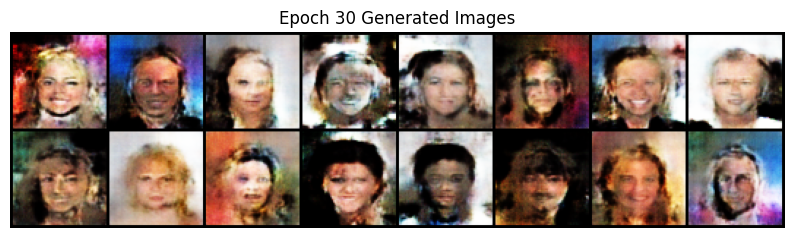

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    g_losses = []
    d_losses = []

    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (real_images, _) in pbar:
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)

            # Train Discriminator (n_critic times per Generator step)
            for _ in range(n_critic):
                optimizer_D.zero_grad()

                real_outputs = discriminator(real_images)
                fake_images = generator(torch.randn(current_batch_size, latent_dim, 1, 1).to(device))
                fake_outputs = discriminator(fake_images.detach())

                d_loss = -torch.mean(real_outputs) + torch.mean(fake_outputs)  # Wasserstein loss
                d_loss.backward()
                optimizer_D.step()

                # Apply weight clipping
                for p in discriminator.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            # Train Generator
            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            g_loss = -torch.mean(fake_outputs)  # Generator loss
            g_loss.backward()
            optimizer_G.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            # Update progress bar
            pbar.set_postfix(D_Loss=np.mean(d_losses), G_Loss=np.mean(g_losses))

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Loss D: {np.mean(d_losses):.4f}, Loss G: {np.mean(g_losses):.4f}")
    G_losses.append(np.mean(g_losses))
    D_losses.append(np.mean(d_losses))
    if (epoch + 1) % 5 == 0:
        # Save samples
        with torch.no_grad():
            z = torch.randn(16, latent_dim, 1, 1).to(device)
            sample_images = generator(z)
            grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
            plt.figure(figsize=(10, 10))
            plt.axis("off")
            plt.title(f"Epoch {epoch+1} Generated Images")
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

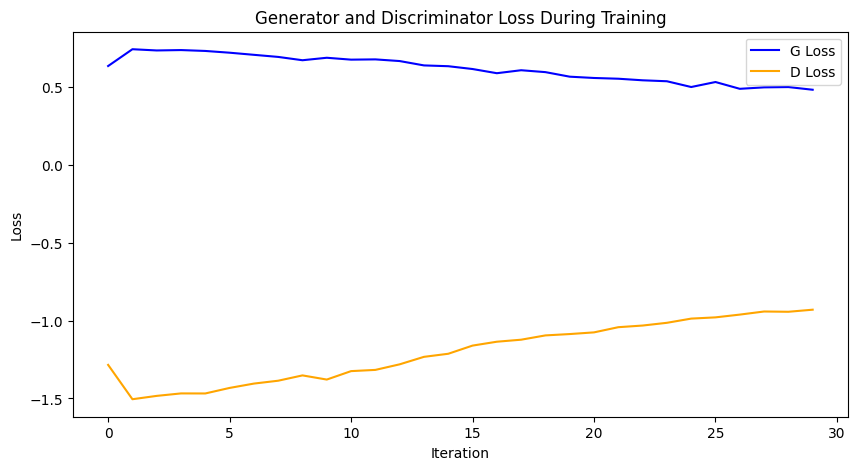

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss", color='blue')
plt.plot(D_losses, label="D Loss", color='orange')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Load InceptionV3 model for IS and FID
inception = inception_v3(weights="IMAGENET1K_V1", transform_input=False)
inception.eval()

# Define transformations for generated images (Inception expects 299x299 images)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

# Function to generate images from the Generator
def generate_images(generator, num_images=100, latent_dim=100, device="cuda"):
    generator.to(device).eval()
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Noise vector
    with torch.no_grad():
        generated_images = generator(noise).cpu()  # Generate images

    # Convert from [-1, 1] to [0, 255] and cast to uint8
    generated_images = (generated_images * 127.5 + 127.5).clamp(0, 255).to(torch.uint8)

    return generated_images

# Function to compute Inception Score
def compute_inception_score(images):
    is_metric = InceptionScore(feature=2048)
    is_metric.update(images)
    score = is_metric.compute()
    return score

# Function to compute Frechet Inception Distance
def compute_fid(real_images, fake_images):
    fid_metric = FrechetInceptionDistance(feature=2048)
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_score = fid_metric.compute()
    return fid_score

# Function to evaluate Generator
def evaluate_generator(generator, real_images, num_images=100, latent_dim=latent_dim, device="cuda"):
    fake_images = generate_images(generator, num_images, latent_dim, device)

    # Convert real images from [-1, 1] to [0, 255] if necessary
    if real_images.dtype != torch.uint8:
        real_images = (real_images * 127.5 + 127.5).clamp(0, 255).to(torch.uint8)

    # Compute IS and FID
    inception_score = compute_inception_score(fake_images)
    fid_score = compute_fid(real_images, fake_images)

    print(f"Inception Score: {inception_score}")
    print(f"Frechet Inception Distance: {fid_score}")

    return inception_score, fid_score

# Get real images from dataloader
dataiter = iter(test_loader)
real_images, labels = next(dataiter)

# Evaluate Generator
temp=evaluate_generator(generator, real_images, num_images=64, latent_dim=latent_dim, device=device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 169MB/s] 
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 296MB/s]


Inception Score: (tensor(1.0412), tensor(0.0159))
Frechet Inception Distance: 213.0339813232422


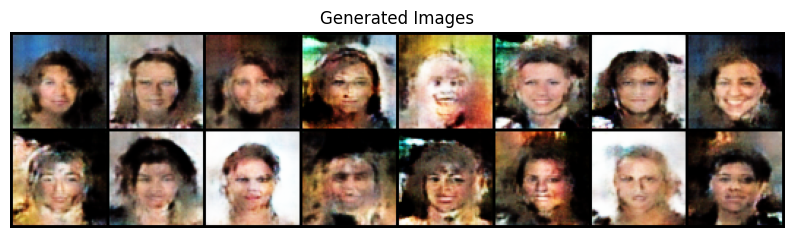

In [ ]:
with torch.no_grad():
    z = torch.randn(16, latent_dim, 1, 1).to(device)
    sample_images = generator(z)
    grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Generated Images")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [ ]:
# Define a CNN classifier for binary classification (Young vs. Old)
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)  # two classes: 0 ("Old") and 1 ("Young")
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
classifier_real = CNNClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier_real.parameters(), lr=0.001)

n_epochs_cls = 20  # Max epochs
patience = 3  # Early stopping patience
best_val_loss = np.inf  # Initialize best validation loss
counter = 0  # Counter for early stopping

for epoch in range(n_epochs_cls):
    classifier_real.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier_real(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs_cls} Training Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    classifier_real.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = classifier_real(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset patience counter
        torch.save(classifier_real.state_dict(), "best_model.pth")  # Save best model
        print("Model Improved! Saving Best Model...")
    else:
        counter += 1
        print(f"No Improvement. Patience: {counter}/{patience}")

    if counter >= patience:
        print("Early Stopping Triggered!")
        break  # Stop training

Epoch 1/20 Training Loss: 0.4569
Validation Loss: 0.4010 | Validation Accuracy: 83.21%
Model Improved! Saving Best Model...
Epoch 2/20 Training Loss: 0.3809
Validation Loss: 0.3737 | Validation Accuracy: 84.08%
Model Improved! Saving Best Model...
Epoch 3/20 Training Loss: 0.3515
Validation Loss: 0.3605 | Validation Accuracy: 84.50%
Model Improved! Saving Best Model...
Epoch 4/20 Training Loss: 0.3314
Validation Loss: 0.3509 | Validation Accuracy: 84.76%
Model Improved! Saving Best Model...
Epoch 5/20 Training Loss: 0.3145
Validation Loss: 0.3622 | Validation Accuracy: 85.01%
No Improvement. Patience: 1/3
Epoch 6/20 Training Loss: 0.2990
Validation Loss: 0.3434 | Validation Accuracy: 85.43%
Model Improved! Saving Best Model...
Epoch 7/20 Training Loss: 0.2824
Validation Loss: 0.3487 | Validation Accuracy: 85.10%
No Improvement. Patience: 1/3
Epoch 8/20 Training Loss: 0.2593
Validation Loss: 0.3538 | Validation Accuracy: 85.36%
No Improvement. Patience: 2/3
Epoch 9/20 Training Loss: 0.2

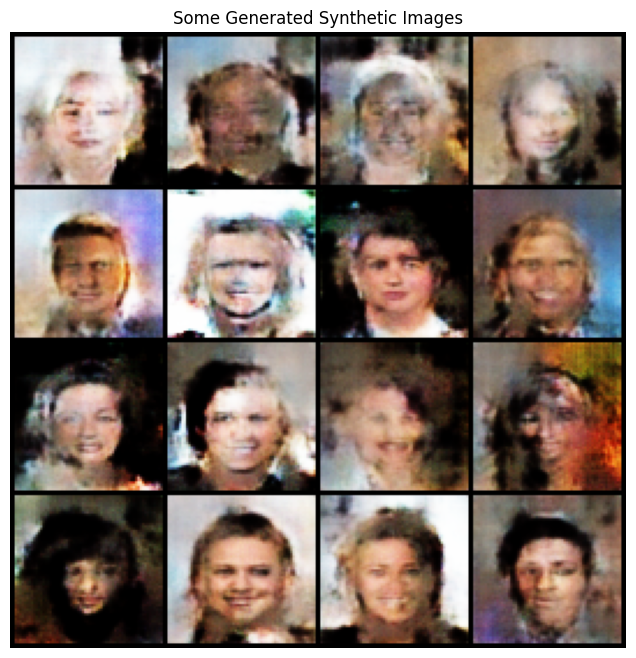

In [ ]:
# Generate synthetic images using the trained generator
def generate_synthetic_images(generator, num_images, latent_dim, device="cuda"):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Reshape to [batch_size, latent_dim, 1, 1]
        fake_imgs = generator(z)
    # Scale images from [-1,1] to [0,1]
    fake_imgs = (fake_imgs + 1) / 2
    return fake_imgs.cpu()


# Generate synthetic images (70% of real training set size)
num_synthetic = int(len(train_dataset) * 0.7)
synthetic_images = generate_synthetic_images(generator, num_synthetic,latent_dim,device)

# Annotate synthetic images using the previously trained classifier on real data
classifier_real.eval()
synthetic_labels = []
with torch.no_grad():
    synth_loader = DataLoader(synthetic_images, batch_size=64, shuffle=False)
    for imgs in synth_loader:
        imgs = imgs.to(device)
        outputs = classifier_real(imgs)
        _, preds = torch.max(outputs, 1)
        synthetic_labels.extend(preds.cpu().numpy())
synthetic_labels = np.array(synthetic_labels)

# Visualize a few synthetic images (without annotation text here; annotation is used later)
grid = torchvision.utils.make_grid(synthetic_images[:16], nrow=4)
np_grid = np.transpose(grid.numpy(), (1, 2, 0))
plt.figure(figsize=(8,8))
plt.imshow(np_grid)
plt.title("Some Generated Synthetic Images")
plt.axis('off')
plt.show()


In [ ]:
import random
from torch.utils.data import TensorDataset, ConcatDataset

# Gather real training images and labels from the train_dataset
real_imgs = []
real_labels = []
for img, label in train_dataset:
    real_imgs.append(img)
    real_labels.append(label)
real_imgs = torch.stack(real_imgs)
real_labels = torch.tensor(real_labels)

# Create TensorDatasets for synthetic and real data
synthetic_dataset = TensorDataset(synthetic_images, torch.tensor(synthetic_labels))
real_dataset = TensorDataset(real_imgs, real_labels)

# We create a combined dataset with 70% synthetic and 30% real samples.
num_total = len(real_dataset)  # use the real training set size as a reference
num_synth_used = int(0.7 * num_total)
num_real_used = num_total - num_synth_used

# Randomly select indices
synth_indices = random.sample(range(len(synthetic_dataset)), num_synth_used)
real_indices = random.sample(range(len(real_dataset)), num_real_used)

subset_synth = torch.utils.data.Subset(synthetic_dataset, synth_indices)
subset_real = torch.utils.data.Subset(real_dataset, real_indices)

# Combine into one dataset
combined_dataset = ConcatDataset([subset_synth, subset_real])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define classifier for the mixed dataset
classifier_mixed = CNNClassifier().to(device)
criterion_mixed = nn.CrossEntropyLoss()
optimizer_mixed = optim.Adam(classifier_mixed.parameters(), lr=0.001)

n_epochs_mixed = 20  # Max epochs
patience = 3  # Early stopping patience
best_val_loss = np.inf  # Initialize best validation loss
counter = 0  # Counter for early stopping

for epoch in range(n_epochs_mixed):
    classifier_mixed.train()
    running_loss = 0.0

    for imgs, labels in combined_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_mixed.zero_grad()
        outputs = classifier_mixed(imgs)
        loss = criterion_mixed(outputs, labels)
        loss.backward()
        optimizer_mixed.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(combined_dataset)
    print(f"Epoch {epoch+1}/{n_epochs_mixed} Training Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    classifier_mixed.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = classifier_mixed(imgs)
            loss = criterion_mixed(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset patience counter
        torch.save(classifier_mixed.state_dict(), "best_model_mixed.pth")  # Save best model
        print("Model Improved! Saving Best Model...")
    else:
        counter += 1
        print(f"No Improvement. Patience: {counter}/{patience}")

    if counter >= patience:
        print("Early Stopping Triggered!")
        break  # Stop training


Epoch 1/20 Training Loss: 0.5829
Validation Loss: 0.5242 | Validation Accuracy: 79.16%
Model Improved! Saving Best Model...
Epoch 2/20 Training Loss: 0.4619
Validation Loss: 0.4394 | Validation Accuracy: 80.84%
Model Improved! Saving Best Model...
Epoch 3/20 Training Loss: 0.4130
Validation Loss: 0.4015 | Validation Accuracy: 82.76%
Model Improved! Saving Best Model...
Epoch 4/20 Training Loss: 0.3809
Validation Loss: 0.3931 | Validation Accuracy: 83.14%
Model Improved! Saving Best Model...
Epoch 5/20 Training Loss: 0.3560
Validation Loss: 0.4063 | Validation Accuracy: 82.89%
No Improvement. Patience: 1/3
Epoch 6/20 Training Loss: 0.3357
Validation Loss: 0.3905 | Validation Accuracy: 82.84%
Model Improved! Saving Best Model...
Epoch 7/20 Training Loss: 0.3144
Validation Loss: 0.3902 | Validation Accuracy: 83.16%
Model Improved! Saving Best Model...
Epoch 8/20 Training Loss: 0.2995
Validation Loss: 0.3949 | Validation Accuracy: 83.76%
No Improvement. Patience: 1/3
Epoch 9/20 Training Lo

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier_mixed.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier_mixed(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_true, all_preds)
precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.8374
Test Precision: 0.8765
Test Recall: 0.9158
Test F1-Score: 0.8957


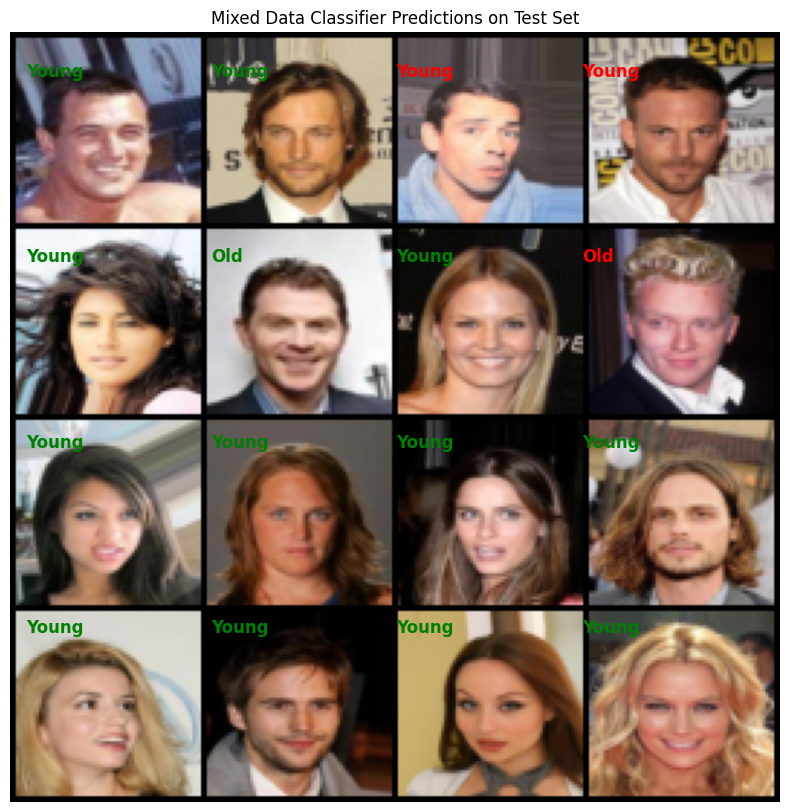

In [ ]:
# Visualize test set predictions with color annotations
def visualize_predictions(model, dataloader, num_images=16):
    dataiter = iter(dataloader)
    imgs, labels = next(dataiter)
    imgs=imgs[:num_images]
    labels=labels[:num_images]
    imgs = imgs.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    grid_img = torchvision.utils.make_grid(imgs.cpu(), nrow=4, normalize=True)
    np_grid = np.transpose(grid_img.numpy(), (1, 2, 0))

    plt.figure(figsize=(10,10))
    plt.imshow(np_grid)
    ax = plt.gca()
    grid_size = 4
    img_size = 64
    for idx in range(num_images):
        row = idx // grid_size
        col = idx % grid_size
        x = col * img_size + 5
        y = row * img_size + 15
        pred_label = "Young" if preds[idx].item() == 1 else "Old"
        color = "green" if preds[idx].item()==labels[idx] else "red"
        ax.text(x, y, pred_label, color=color, fontsize=12, weight='bold')

    plt.title("Mixed Data Classifier Predictions on Test Set")
    plt.axis('off')
    plt.show()

visualize_predictions(classifier_mixed, test_loader, num_images=16)